---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

---

In [2]:
def get_correspondences(image1, image2):
    grayimage1= cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    grayimage2= cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    sift= cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(grayimage1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(grayimage2, None)
    bf= cv2.BFMatcher()
    matches= bf.knnMatch(descriptors1, descriptors2, k=2)
    good_matches=[]  # Apply ratio test to find good matches
    for m, n in matches:
        if m.distance < 0.75 * n.distance: #not ambigous
            good_matches.append(m)

    good_matches.sort(key=lambda match: match.distance)
    good_matches= good_matches[:50]


    points1= np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2= np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    return points1, points2

In [3]:
def plot_correspondences(image1, image2, points1, points2):


    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    combined_image = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    combined_image[:h1, :w1] = image1
    combined_image[:h2, w1:w1 + w2] = image2

    # Plot the combined image
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))

    # Draw lines connecting the corresponding points
    for p1, p2 in zip(points1, points2):
        x1, y1 = p1
        x2, y2 = p2
        x2 += w1  # Offset the x-coordinate of the second image
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
        plt.scatter([x1, x2], [y1, y2], c='yellow', s=10)

    plt.axis("off")
    plt.title("Correspondences Between Images")
    plt.show()


In [4]:
def compute_homography(points1, points2):
    n= points1.shape[0]
    A=[]

    for i in range(n):
        x1, y1 = points1[i]
        x2, y2 = points2[i]

        A.append([-x1, -y1, -1, 0, 0, 0, x1* x2, y1 * x2, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1 * y2, y1 * y2, y2])

    A = np.array(A)
    #svd
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))
    H /= H[2, 2]
    return H


In [15]:
def forward_warp(image, H, output_shape):
    h, w = image.shape[:2]
    output_h, output_w = output_shape
    warped = np.zeros((output_h, output_w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            # Transform the point using H
            point = np.array([x, y, 1], dtype=np.float64)
            transformed = np.dot(H, point)
            transformed /= transformed[2]  # Normalize homogeneous coordinates

            # Map transformed coordinates to the source image
            tx, ty = transformed[0], transformed[1]

            # Round to nearest integer and check bounds for the output image
            tx_int, ty_int = int(round(tx)), int(round(ty))
            if 0 <= tx_int < output_w and 0 <= ty_int < output_h:  # Within bounds of output image
                warped[ty_int, tx_int] = image[y, x]

    return warped


def inverse_warp(image, H, output_shape):
    h, w= output_shape[:2]
    warped= np.zeros((h, w, 3), dtype=np.uint8)

    H_inv = np.linalg.inv(H)
    for y in range(h):
        for x in range(w):

            point= np.array([x, y, 1])
            transformed= np.dot(H_inv, point)
            transformed /= transformed[2]

            tx, ty= transformed[0], transformed[1]

            if 0 <= tx < image.shape[1] and 0 <= ty < image.shape[0]:
                #bilinear interpolation
                x1, y1= int(tx), int(ty)
                x2, y2= min(x1 + 1, image.shape[1] - 1), min(y1 + 1, image.shape[0] - 1)

                a, b = tx - x1, ty - y1

                value = (1 - a) * (1 - b) * image[y1, x1] + \
                        a * (1 - b) * image[y1, x2] + \
                        (1 - a) * b * image[y2, x1] + \
                        a * b * image[y2, x2]

                warped[y, x] = value.astype(np.uint8)
    return warped


---

In [8]:
def create_mosaic_2images(image1, image2, H , forward =  False):
    h1, w1= image1.shape[:2]
    h2, w2= image2.shape[:2]

    corners= np.array([[0, 0, 1], [w2, 0, 1], [0, h2, 1], [w2, h2, 1]])
    transformed_corners= np.dot(H, corners.T).T
    transformed_corners /= transformed_corners[:, 2][:, None]  # Normalize by the third coordinate

    min_x= int(min(transformed_corners[:, 0].min(), 0))
    max_x= int(max(transformed_corners[:, 0].max(), w1))
    min_y= int(min(transformed_corners[:, 1].min(), 0))
    max_y= int(max(transformed_corners[:, 1].max(), h1))

    offset= np.array([[1, 0, -min_x],
                       [0, 1, -min_y],
                       [0, 0, 1]])

    canvas_width= max_x - min_x
    canvas_height= max_y - min_y
    canvas_shape= (canvas_height, canvas_width, 3)
    fun = forward_warp if forward else inverse_warp
    warped_image2= fun(image2, np.dot(offset, H), canvas_shape)
    canvas= np.zeros(canvas_shape, dtype=np.uint8)
    canvas[-min_y:h1 - min_y, -min_x:w1 - min_x] = image1

    mask= (warped_image2 > 0).astype(np.uint8)
    canvas[mask > 0]= warped_image2[mask > 0]

    return canvas


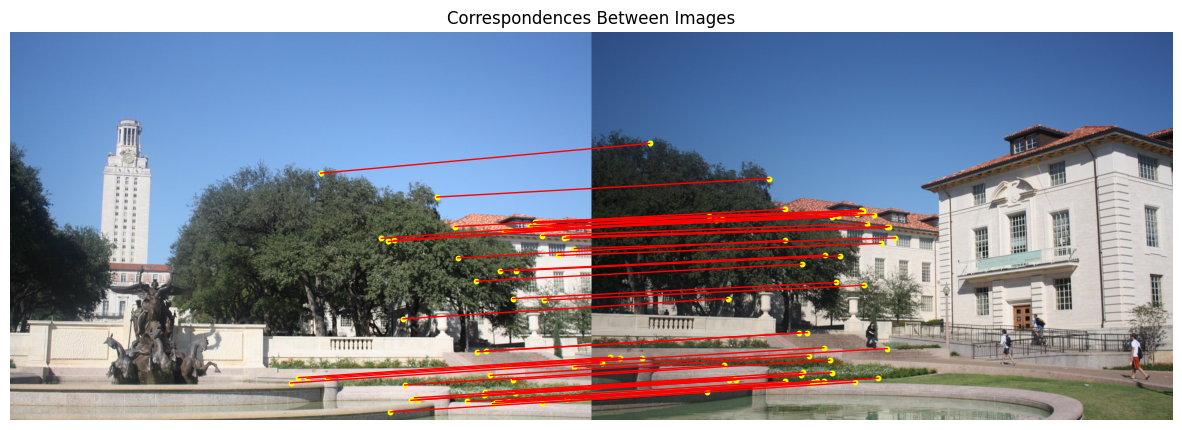

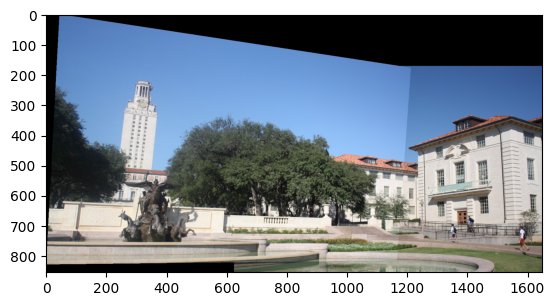

In [9]:
image1= cv2.imread("/content/pano_image1.jpg")
image2= cv2.imread("/content/pano_image2.jpg")

points1, points2= get_correspondences(image2, image1)
plot_correspondences(image2, image1, points1, points2)

H= compute_homography(points1, points2)
mosaic= create_mosaic_2images(image1, image2, H)
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.show()

---

#Mosaicing of 3 Images (Here we take second frame as refrence frame)#

---

In [10]:
def create_mosaic_3_images(image1, image2, image3, H_12, H_32 , forward =  False):
    h1, w1 = image1.shape[:2] #size of each image
    h2, w2 = image2.shape[:2]
    h3, w3 = image3.shape[:2]

    corners_image1= np.array([[0, 0, 1], [w1, 0, 1], [0, h1, 1], [w1, h1, 1]])
    corners_image2= np.array([[0, 0, 1], [w2, 0, 1], [0, h2, 1], [w2, h2, 1]])
    corners_image3= np.array([[0, 0, 1], [w3, 0, 1], [0, h3, 1], [w3, h3, 1]])

    #the corner points of image1 and image3 transformed into plane of image2(refrence)
    transformed_corners1 = np.dot(H_12, corners_image1.T).T
    transformed_corners1 /= transformed_corners1[:, 2][:, None]
    transformed_corners3 = np.dot(H_32, corners_image3.T).T
    transformed_corners3 /= transformed_corners3[:, 2][:, None]

    min_x= int(min(0, transformed_corners1[:, 0].min(), transformed_corners3[:, 0].min())) #box pound all images
    max_x= int(max(w2, transformed_corners1[:, 0].max(), transformed_corners3[:, 0].max()))
    min_y= int(min(0, transformed_corners1[:, 1].min(), transformed_corners3[:, 1].min()))
    max_y= int(max(h2, transformed_corners1[:, 1].max(), transformed_corners3[:, 1].max()))

    canvas_width= max_x - min_x #canvas size and offset matrix
    canvas_height= max_y - min_y
    offset= np.array([[1, 0, -min_x],
                       [0, 1, -min_y],
                       [0, 0, 1]])

    H_12_offset= np.dot(offset, H_12)
    H_32_offset= np.dot(offset, H_32)

    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    fun  = forward_warp if forward else inverse_warp
    warped_image1 = fun(image1, H_12_offset, (canvas_height, canvas_width))
    warped_image2 = fun(image2, offset, (canvas_height, canvas_width))  #Image2 remains fixed
    warped_image3 = fun(image3, H_32_offset, (canvas_height, canvas_width))

    canvas = np.maximum(canvas, warped_image2)  #Use image2 as the base
    canvas = np.maximum(canvas, warped_image1)  #stith image1
    canvas = np.maximum(canvas, warped_image3)  #stitch image3

    return canvas


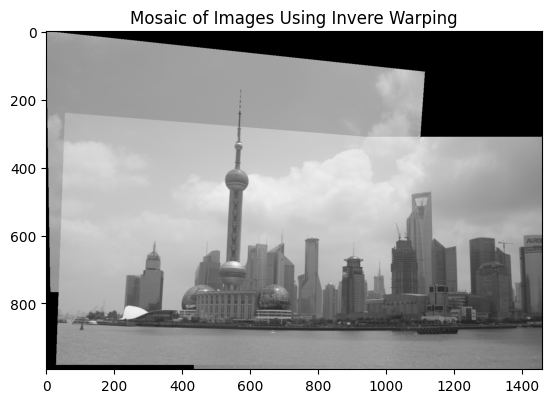

In [11]:
image1 = cv2.imread("/content/shanghai-21.png")
image2 = cv2.imread("/content/shanghai-23.png")  # Reference frame!!
image3 = cv2.imread("/content/shanghai-22.png")

points1, points2 = get_correspondences(image1, image2)
points3, points2x = get_correspondences(image3, image2)

H12= compute_homography(points1, points2)
H32= compute_homography(points3, points2x)
mosaic= create_mosaic_3_images(image1, image2, image3, H12, H32)
plt.title("Mosaic of Images Using Invere Warping")
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.show()


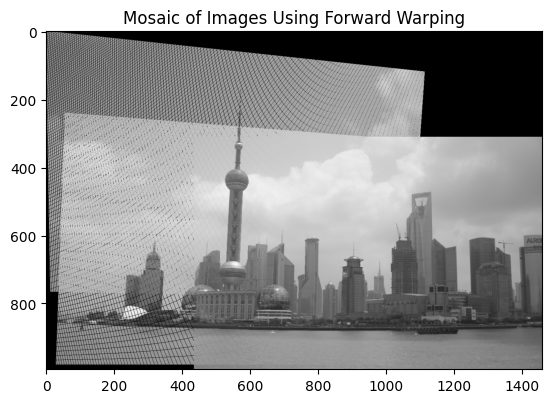

In [16]:
image1 = cv2.imread("/content/shanghai-21.png")
image2 = cv2.imread("/content/shanghai-23.png")  # Reference frame!!
image3 = cv2.imread("/content/shanghai-22.png")

points1, points2 = get_correspondences(image1, image2)
points3, points2x = get_correspondences(image3, image2)

H12= compute_homography(points1, points2)
H32= compute_homography(points3, points2x)
mosaic= create_mosaic_3_images(image1, image2, image3, H12, H32 , True )
plt.title("Mosaic of Images Using Forward Warping")
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.show()


---

---